In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main")
import anndata as ad
import networkx as nx
import scanpy as sc
import switch2 as sw
from itertools import chain

In [2]:
import os
os.chdir("../../../DATA/Mouse_embryo/")
rna = sc.read_h5ad("rna.h5ad")
atac = sc.read_h5ad("peakMat.h5ad")

In [3]:
sw.pp.get_gene_annotation(rna, 
                          gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
                          gtf_by="gene_name",
                          drop_na=True
                          )

- INFO - 1919 genes were not annotated and dropped.


In [4]:
rna.layers["counts"] = rna.X.copy()
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

In [5]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# print(i.var)

In [6]:
guidance = sw.pp.rna_anchored_guidance_graph(rna, atac)
# guidance

window_graph: 100%|██████████| 15139/15139 [00:02<00:00, 6940.50it/s]


In [7]:
# rna.write("rna-pp.h5ad", compression="gzip")
# atac.write("atac-pp.h5ad", compression="gzip")
# nx.write_graphml(guidance, "guidance.graphml.gz")

In [8]:
# rna = ad.read_h5ad("rna-pp.h5ad")
# atac = ad.read_h5ad("atac-pp.h5ad")
# guidance = nx.read_graphml("guidance.graphml.gz")

In [9]:
sc.pp.filter_genes(atac, min_cells=20)
len(atac.var[atac.var["highly_variable"]==True])

17249

In [10]:
atac.obs_names = [i.split("-")[0] for i in atac.obs_names]
atac = atac[rna.obs_names]
atac.obsm["spatial"] = rna.obsm["spatial"]

In [11]:
sw.pp.setup_data(
    rna, "NB",
    use_highly_variable=True,
    use_layer="counts",
)
sw.pp.setup_data(
    atac, "NB",
    use_highly_variable=True, 
)

In [12]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [13]:
# sc.pp.neighbors(atac, use_rep="X_lsi")
# sc.tl.leiden(atac, key_added="coarse_leiden", resolution=0.3)
# sc.pl.spatial(atac, spot_size=1, color="coarse_leiden")

In [14]:
sw.pp.cal_spatial_net(rna, cutoff=1, model="Radius")
sw.pp.cal_spatial_net(atac, cutoff=1, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 8350 edges, 2187 spots.
3.8180 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 8350 edges, 2187 spots.
3.8180 neighbors per spot on average.


In [15]:
model = sw.SWITCH(adatas={"rna": rna, "atac": atac},
                  vertices=sorted(guidance_hvf.nodes),
                  dropout=0.25,)

- INFO - Set random seed to 0
- INFO - GPU available: True, used device: GPU 0


In [16]:
model.compile(lam_graph=0.35,
              lam_align=0.3,
              dsc_lr=5e-5,)

In [17]:
model.pretrain(adatas={"rna": rna, "atac": atac},
               graph=guidance_hvf,
               max_epochs=3000,
               dsc_k=4,)

- INFO - Prepare data for training.
- INFO - Pretraining with full batch.
Epoch 3000/3000: 100%|██████████| 3000/3000 [04:14<00:00, 11.77it/s, dsc_loss=0.693, gen_loss=0.352]
- INFO - Model pretrain done.


In [18]:
model.train(adatas={"rna": rna, "atac": atac},
            graph=guidance_hvf,
            max_epochs=800,
            dsc_k=12)

- INFO - Training with full batch.
Epoch 800/800: 100%|██████████| 800/800 [05:30<00:00,  2.42it/s, dsc_loss=0.690, gen_loss=0.922, cycle_loss=0.347, align_loss=0.755]
- INFO - Model training done.


In [757]:
model.load("/mnt/datadisk/lizhongzhan/SpaMultiOmics/SCRIPT/Figure1/SWITCH/T1_test/model_3.pth") # 2, 3, 15, 27, 33, 41, 45, 46

- INFO - Model loaded from '/mnt/datadisk/lizhongzhan/SpaMultiOmics/SCRIPT/Figure1/SWITCH/T1_test/model_3.pth'


In [758]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [759]:
combined = ad.concat([rna, atac], label="omics")

In [760]:
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30,)# metric="cosine")
sc.tl.umap(combined)

In [761]:
sc.tl.leiden(adata=combined, resolution=.6, key_added="clus")
print(len(set(combined.obs["clus"])))

14


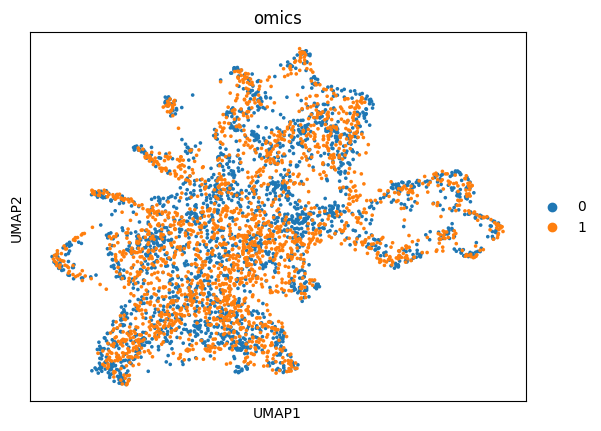

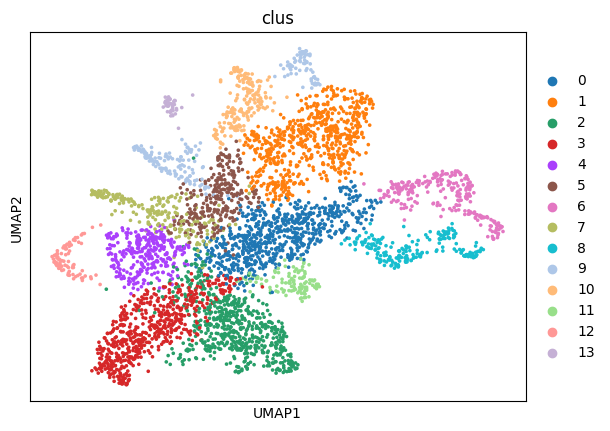

In [762]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="clus")

In [763]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

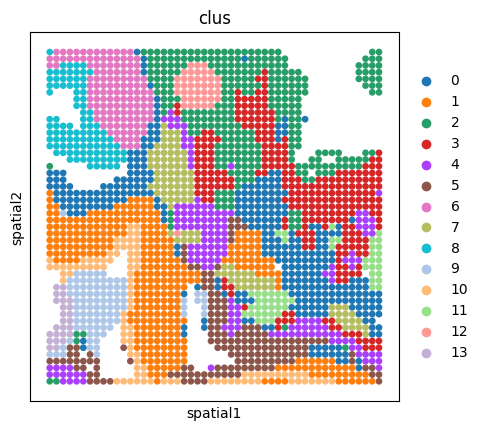

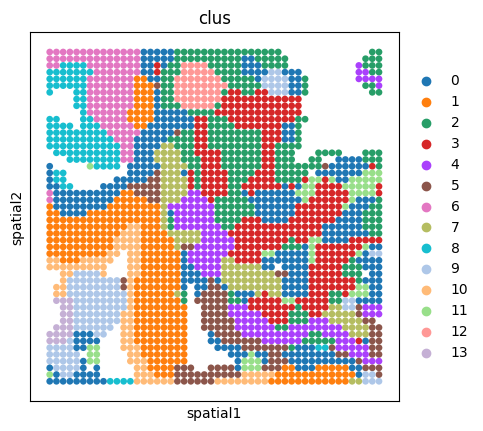

In [764]:
sc.pl.spatial(t_rna, color="clus",spot_size=1)
sc.pl.spatial(t_atac, color="clus",spot_size=1)

In [765]:
x=sw.metrics.foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])
x

0.11559075544917813

In [766]:
# import pandas as pd
# cluster = combined.obs['leiden']
# cluster.to_csv("rep1/SWITCH_cluster.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")

In [767]:
imputed_rna =  model.impute_data(source_key="atac",target_key="rna", source_adata=atac, graph=guidance_hvf)
imputed_rna = ad.AnnData(X=np.array(imputed_rna))
imputed_rna.var["highly_variable"] = True
imputed_rna.obsm["spatial"] = rna.obsm["spatial"]
imputed_rna.var_names = list(rna[:,rna.var["highly_variable"]].var_names)

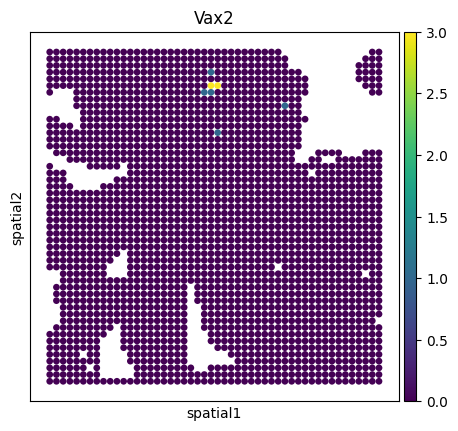

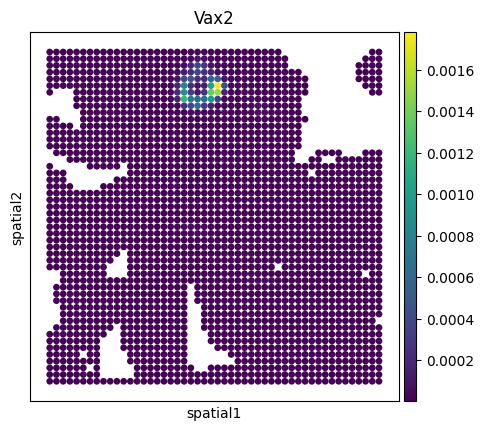

In [768]:
sc.pl.spatial(rna, color="Vax2", spot_size=1)
sc.pl.spatial(imputed_rna, color="Vax2", spot_size=1)

In [1]:
# imputed_atac =  model.impute_data(source_key="rna",target_key="atac",source_adata=rna, target_adata=atac, graph=guidance_hvf,target_libsize=1e4)
# imputed_atac = ad.AnnData(X=np.array(imputed_atac))
# imputed_atac.var["highly_variable"] = True
# imputed_atac.obsm["spatial"] = atac.obsm["spatial"]
# imputed_atac.var_names = list(atac[:,atac.var["highly_variable"]].var_names)
# imputed_rna.write("imputed_rna.h5ad")
# imputed_atac.write("imputed_atac.h5ad")